In [ ]:
from TCFile import TCFile
import numpy as np
import napari
import analysis
from skimage import morphology, filters, feature, measure
from tqdm import tqdm
import ipywidgets as widgets
import matplotlib.pyplot as plt
import pandas as pd

viewer = napari.Viewer()

<h3> Sobel Filter 써본거 </h3>

In [ ]:
import h5py
a = h5py.File(r"C:\rkka_Projects\Cell\Data\Necroptosis\csv\timelapsed_compressed_230510.174730.HeLa_Hoechst.001.Group1.A2.T001P02.TCF.h5")
viewer.add_image(a['labels/00h'])
aa = a[28:34]

aa = filters.sobel(aa)
thr = filters.threshold_multiotsu(aa, 4)
aa[aa<thr[1]] = 0

aa = morphology.remove_small_objects(aa.astype(bool), 4096)
aa = morphology.dilation(aa)
aa = morphology.dilation(aa)

for i, slice in enumerate(aa):
    slice = morphology.area_closing(slice, area_threshold=8192)
    aa[i] = slice

In [ ]:
thresholds = filters.threshold_multiotsu(a, 5)
slices = np.zeros(a[27:33].shape)
slices = slices + a[27:33]
slices[slices<thresholds[1]] = a.min()

slices = morphology.dilation(slices)
slices = filters.gaussian(slices)

slices = slices.astype(float)

In [ ]:
edge = filters.sobel(slices)
edge_thr = filters.threshold_multiotsu(edge, 3)
edge[edge < edge_thr[1]] = 0

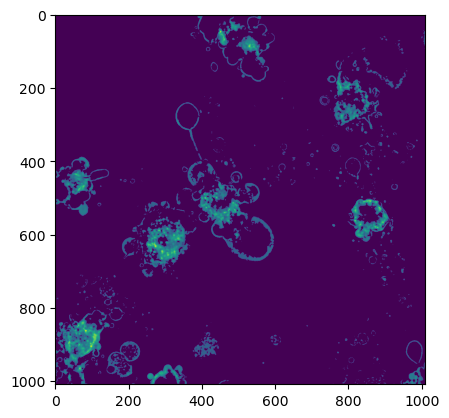

In [ ]:
plt.imshow(edge[3])

In [ ]:
viewer.add_image(edge)

<Image layer 'Image [1]' at 0x24f51e628b0>

<h3> Segment Anything Model(SAM) 이용한 시도 </h3>

In [ ]:
thresholds = filters.threshold_multiotsu(a, 5)
slices = np.zeros(a[27:33].shape)
slices = slices + a[27:33]
slices[slices<thresholds[1]] = 0
slices = slices.astype(float)


for i, slice in enumerate(tqdm(slices, desc='Processing slices')):
    
    seg = analysis.make_array_3ch(slice)
    seg = analysis.segment_anything(seg)
    
    temp = np.zeros(slice.shape)
    for s in seg:
        # slice * s['segmentation'] : multiplication is important to remove background
        # temp = temp + slice * s['segmentation']
        temp = temp + s['segmentation']
    
    slices[i, :, :] = temp

Processing slices: 100%|██████████| 6/6 [00:53<00:00,  8.97s/it]


In [ ]:
viewer.add_image(slices)

<Image layer 'slices' at 0x2099be22fd0>

<h3> Peak local max를 통해, threshold 걸어준 이미지에서 국소적 최댓값들을 가지는 점들을 표시 </h3>

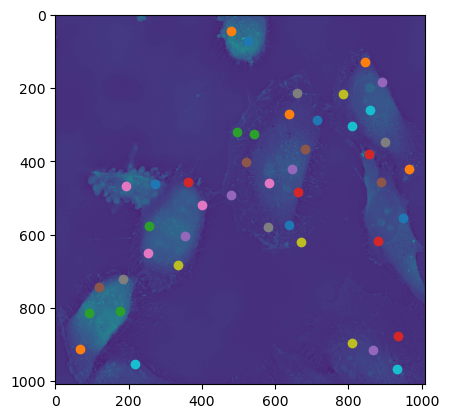

In [ ]:
from skimage import feature
p = feature.peak_local_max(a[30,:,:], min_distance=40, threshold_abs=thresholds[3])

plt.figure()
for i in range(p.shape[0]):
    plt.scatter(x=p[i][1], y=p[i][0])
plt.imshow(a[30,:,:])

<h3> 앞서구한 Peak locam maximum들을 중심으로 Watershed segmentation 시도 </h3>

In [ ]:
from scipy import ndimage as ndi
from skimage import segmentation, feature
from tqdm import tqdm

aa = np.zeros(a.shape)

for z in tqdm(range(a.shape[0])):
    t = a[z,:,:]
    t[t<thresholds[1]]=0
    t = t.astype(bool)
    distance = ndi.distance_transform_edt(t)

    coords = feature.peak_local_max(distance, labels=t)

    mask = np.zeros(distance.shape, dtype=bool)
    mask[tuple(coords.T)] = True
    markers, _ = ndi.label(mask)
    labels = segmentation.watershed(-distance, markers, mask=t)

    aa[z,:,:] = t

NameError: name 'np' is not defined

<h3> Random walker segmentation시도 </h3>

In [ ]:
from skimage import segmentation
from tqdm import tqdm

aa = np.zeros(a.shape)

for i in tqdm(range(a.shape[0])):
    tmp = a[i,:,:]
    markers = np.zeros(tmp.shape)
    markers[tmp < thresholds[0]] = 1
    markers[tmp > thresholds[1]] = 2

    labels = segmentation.random_walker(tmp, markers)
    aa[i,:,:] = labels

  0%|          | 0/59 [00:00<?, ?it/s]c:\miniconda3\envs\lab\lib\site-packages\skimage\_shared\utils.py:438: UserWarning: The probability range is outside [0, 1] given the tolerance `prob_tol`. Consider decreasing `beta` and/or decreasing `tol`.
  return func(*args, **kwargs)
100%|██████████| 59/59 [00:44<00:00,  1.33it/s]


<h3> Sobel Filter 이용해서 edge 따기 </h3>

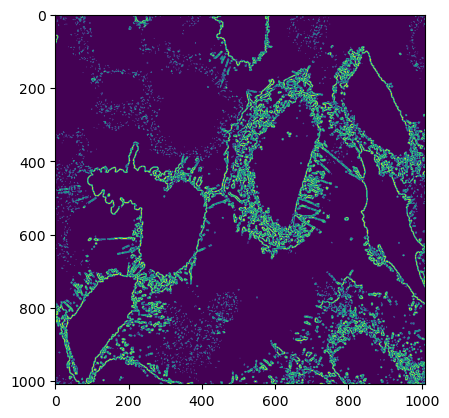

In [ ]:
s = filters.sobel(filters.gaussian(mask[30,:,:]))
thr = filters.threshold_multiotsu(s, 3)
s[s<thr[1]] = 0
s[s>thr[1]] = 0.05
plt.imshow(s)

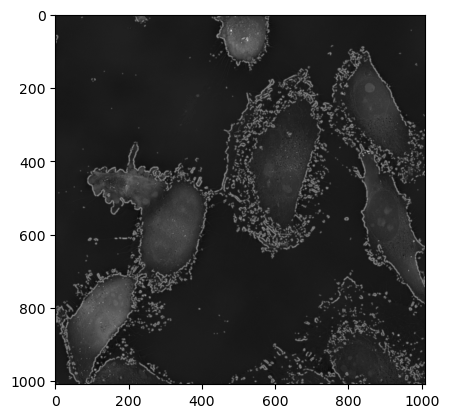

In [ ]:
ss = filters.gaussian(morphology.dilation(morphology.erosion(s)))
mm = mask[30,:,:]
plt.imshow(ss+a[30,:,:], 'gray')